**Imports**

In [26]:
import pandas as pd
import numpy as np
import networkx as nx
import zlib
import pickle
import os
import matplotlib.pyplot as plt
from itertools import combinations
import sys

compressed_sizes = {}


**Load dataset**

In [2]:
def load_dataset(file_path):
    df = pd.read_csv(file_path, sep='\t', header=0, usecols=[0, 1, 2, 3])  # Ignore extra columns
    return df

**Dictionary with pre-computed values**

In [3]:
def compute_compressed_sizes(user_ratings):
    
    for user, ratings in user_ratings.items():
        u_string = "".join(f"{k}:{v}" for k, v in sorted(ratings.items()))
        compressed_sizes[u_string] = len(zlib.compress(u_string.encode()))
    
    return compressed_sizes


**Similarities**

In [77]:
def linear_similarity(ratings_u, ratings_v):
    common_items = set(ratings_u.keys()).intersection(set(ratings_v.keys()))
    if not common_items:
        return 0  # If no common items, similarity is 0

    diff_sum = sum(abs(ratings_u[i] - ratings_v[i]) for i in common_items)
    ls_value = 1 - (diff_sum / len(common_items))
    print("ls_value: ", ls_value)
    return max(0, ls_value)  # Ensure similarity is non-negative

# Compression Similarity with precomputed sizes
def compression_similarity(ratings_u, ratings_v):
    u_string = "".join(f"{k}:{v}" for k, v in sorted(ratings_u.items()))
    v_string = "".join(f"{k}:{v}" for k, v in sorted(ratings_v.items()))
    c_uv = len(zlib.compress((u_string + v_string).encode()))
    c_u = compressed_sizes[u_string]
    c_v = compressed_sizes[v_string]
    return 1 - (c_uv - min(c_u, c_v)) / max(c_u, c_v)

# Kolmogorov Similarity with precomputed sizes
def kolmogorov_similarity(ratings_u, ratings_v):
    u_string = "".join(f"{k}:{v}" for k, v in sorted(ratings_u.items()))
    v_string = "".join(f"{k}:{v}" for k, v in sorted(ratings_v.items()))
    c_u = compressed_sizes[u_string]
    c_v = compressed_sizes[v_string]
    return 1 / (1 + abs(c_u - c_v))


**Simlarity Matrix and graph**

In [81]:
# Compute user similarity matrix and construct graph (with precomputed sizes)
def compute_similarity_matrix(user_ratings, similarity_measure, compressed_sizes):
    similarity_graph = nx.Graph()
    for (u, v) in combinations(user_ratings.keys(), 2):
        sim = similarity_measure(user_ratings[u], user_ratings[v])
        if sim > 0.85:
            similarity_graph.add_edge(u, v, weight=sim)
    return similarity_graph

# Detect user clusters from similarity graph
def detect_groups(similarity_graph):
    return list(nx.connected_components(similarity_graph))

**Reputation-based intra-clustering**

In [ ]:
def compute_cluster_ratings(df, user_groups):
    """ Compute initial ratings per cluster based only on the items rated by users in the cluster. """
    cluster_item_ratings = {}

    for cluster_idx, user_set in enumerate(user_groups, start=1):
        cluster_df = df[df["user_id"].isin(user_set)]
        item_avg_ratings = cluster_df.groupby("item_id")["normalized_rating"].mean().to_dict()
        cluster_item_ratings[cluster_idx] = item_avg_ratings
    
    return cluster_item_ratings

def fill_missing_ratings(cluster_item_ratings, total_items=20000):
    """Fill missing ratings for the largest clusters by borrowing from other clusters."""
    sorted_clusters = sorted(cluster_item_ratings.keys(), key=lambda c: len(cluster_item_ratings[c]), reverse=True)
    top_clusters = sorted_clusters[:3]
    
    for cluster in top_clusters:
        missing_items = set(range(1, total_items + 1)) - set(cluster_item_ratings[cluster].keys())
        for item in missing_items:
            for donor_cluster in sorted_clusters:
                if item in cluster_item_ratings[donor_cluster]:
                    cluster_item_ratings[cluster][item] = cluster_item_ratings[donor_cluster][item]
                    break
        cluster_item_ratings[cluster] = dict(sorted(cluster_item_ratings[cluster].items()))
        print(f"CLUSTER {cluster}: {len(cluster_item_ratings[cluster])} items rated", cluster_item_ratings[cluster])
    
    return cluster_item_ratings

def compute_reputation_adjusted_ratings(df, cluster_item_ratings, user_groups, lambda_factor=0.95, tol=1e-6):
    """ Iteratively adjust ratings based on user reputation until convergence. """

    # Sort clusters based on size (number of items rated) in descending order.
    sorted_clusters = sorted(cluster_item_ratings.keys(), key=lambda c: len(cluster_item_ratings[c]), reverse=True)

    # Select the top 3 largest clusters.
    top_clusters = sorted_clusters[:3]

    # Initialize previous ratings with the initial ratings for the top clusters.
    prev_ratings = {c: cluster_item_ratings[c].copy() for c in top_clusters}

    converged = False

    # Iterate until convergence (ratings dont change after one iteration).
    while not converged:
        new_ratings = {}  
        converged = True 

        # Iterate through each of the top clusters.
        for cluster in top_clusters:
            # Get all user IDs belonging to the current cluster.
            cluster_users = user_groups[cluster - 1]  # -1 because user_groups is zero indexed but cluster index starts at 1.

            # Filter the DataFrame to include only ratings from users in the current cluster.
            cluster_df = df[df["user_id"].isin(cluster_users)]

            # Copy the previous ratings for this cluster to use as a starting point.
            item_ratings = prev_ratings[cluster].copy()

            user_reputation = {}  # Store the reputation scores for users in this cluster.

            # Compute reputation scores for each user in the cluster.
            for user in cluster_users:
                # Filter the cluster's DataFrame to get ratings from the current user.
                user_ratings = cluster_df[cluster_df["user_id"] == user]

                # Calculate the total difference between the user's ratings and the current item ratings.
                errors = [(user_ratings[user_ratings["item_id"] == item]["normalized_rating"].values[0] - item_ratings[item])
                          for item in user_ratings["item_id"] if item in item_ratings]
                          
                # Calculate the total error, divided by number of ratings the user has.
                avg_error = np.sum(errors) / len(user_ratings) if errors else 0

                # Calculate the user's reputation score. Ensure it's non-negative.
                user_reputation[user] = max(0, 1 - lambda_factor * avg_error)

            # Compute new weighted averages for item ratings based on user reputations.
            new_item_ratings = item_ratings.copy()  # Start with existing ratings.

            # Iterate through each item in the cluster's item ratings.
            for item in item_ratings.keys():
                # Filter the cluster's DataFrame to get ratings for the current item.
                ratings = cluster_df[cluster_df["item_id"] == item]

                # Extract the reputation weights and rating values for users who rated the current item.
                weights = np.array([user_reputation[user] for user in ratings["user_id"] if user in user_reputation])
                values = np.array([ratings[ratings["user_id"] == user]["normalized_rating"].values[0] for user in ratings["user_id"] if user in user_reputation])
       
                # Calculate the new weighted average rating for the item.
                if len(weights) > 0 and sum(weights) > 0:
                    new_item_ratings[item] = np.dot(weights, values) / len(weights)

            # Store the new item ratings for the cluster.
            new_ratings[cluster] = new_item_ratings

            # Check for convergence: compare new ratings with previous ratings.
            print("ITERATION")
            for item in new_item_ratings.keys():
                # If the difference between the new rating and the previous rating exceeds the tolerance,
                # set the convergence flag to False.
                if abs(new_item_ratings[item] - prev_ratings[cluster].get(item, 0)) > tol:
                    converged = False

        # Update the previous ratings with the newly computed ratings for the next iteration.
        prev_ratings = new_ratings.copy()

    # Print the final converged ratings.
    print("new_ratings: ", new_ratings)

    # Return the converged ratings.
    return new_ratings

def calculate_item_averages(clusters):
    # Dictionary to store the aggregated items and their cluster appearances
    item_sums = {}
    item_counts = {}

    # Iterate through each cluster to gather data
    for cluster, items in clusters.items():
        for item, value in items.items():
            if item not in item_sums:
                item_sums[item] = 0
                item_counts[item] = 0
            item_sums[item] += value
            item_counts[item] += 1

    # Calculate the averages with one decimal place
    item_averages = {item: round(item_sums[item] / item_counts[item], 1) for item in item_sums}

    return item_averages




**Main function**

In [63]:

# Main execution
file_path = "/home/martim/Desktop/tese/datasets/book_crossing/book_ratings_normalized.dat"
df = load_dataset(file_path)

# Prepare user ratings
user_ratings = {user: dict(zip(group["item_id"], group["normalized_rating"])) for user, group in df.groupby("user_id")}

# Compute or load compressed sizes
compressed_sizes = compute_compressed_sizes(user_ratings)
print("comprimido")

comprimido


**Clustering**

In [82]:
# Choose similarity measure: linear_similarity, compression_similarity, kolmogorov_similarity
similarity_graph = compute_similarity_matrix(user_ratings, linear_similarity, compressed_sizes)

# Detect user clusters from similarity graph
user_groups = list(nx.connected_components(similarity_graph))

# Print the number of detected clusters
print(f"User groups: {(user_groups)}")

print("number of user_groups: ", len(user_groups))



ls_value:  1.0
ls_value:  0.7999999999999999
ls_value:  0.7
ls_value:  0.9
ls_value:  0.8333333333333334
ls_value:  1.0
ls_value:  0.5
ls_value:  0.9
ls_value:  0.9
ls_value:  0.8
ls_value:  0.925
ls_value:  0.7999999999999999
ls_value:  0.9
ls_value:  0.8
ls_value:  0.9
ls_value:  0.7999999999999999
ls_value:  0.9
ls_value:  1.0
ls_value:  1.0
ls_value:  0.8
ls_value:  0.9
ls_value:  1.0
ls_value:  0.9
ls_value:  0.9
ls_value:  0.8333333333333334
ls_value:  0.7999999999999999
ls_value:  0.9
ls_value:  0.9
ls_value:  0.95
ls_value:  0.7
ls_value:  0.9
ls_value:  0.8
ls_value:  0.8999999999999999
ls_value:  1.0
ls_value:  0.9
ls_value:  0.8999999999999999
ls_value:  0.9
ls_value:  0.9
ls_value:  0.9
ls_value:  0.8499999999999999
ls_value:  0.8999999999999999
ls_value:  0.85
ls_value:  0.7
ls_value:  0.65
ls_value:  0.8999999999999999
ls_value:  0.9
ls_value:  0.8999999999999999
ls_value:  0.9
ls_value:  0.9
ls_value:  0.9
ls_value:  1.0
ls_value:  1.0
ls_value:  0.8
ls_value:  0.9
ls_va

**Ranking computation**


CLUSTER 1: 14684 items rated {1: 0.6, 2: 0.8333333333333334, 3: 0.875, 4: 0.775, 5: 0.7818181818181817, 6: 0.8800000000000001, 7: 1.0, 8: 0.3964285714285714, 9: 0.7941176470588235, 10: 0.8032258064516129, 11: 0.9, 13: 0.72, 14: 0.9095890410958904, 15: 0.9285714285714286, 16: 0.7666666666666666, 17: 0.9, 18: 0.7666666666666666, 19: 0.7833333333333333, 20: 0.8647058823529411, 21: 0.6045454545454546, 22: 0.8066666666666666, 23: 0.725, 24: 0.7142857142857143, 25: 0.8060606060606061, 26: 1.0, 27: 0.6, 28: 0.825, 29: 0.7, 31: 0.77, 32: 0.8142857142857143, 34: 0.7, 35: 0.75, 36: 0.825925925925926, 37: 0.9066666666666666, 38: 0.85625, 39: 0.8, 40: 0.825, 41: 0.7333333333333334, 42: 0.8, 43: 0.8, 44: 0.7722222222222223, 45: 0.8, 46: 0.8, 48: 0.8114285714285714, 49: 0.7571428571428571, 50: 0.86, 51: 0.7333333333333334, 52: 0.8, 53: 0.7722222222222223, 54: 0.8730769230769231, 55: 0.8272727272727273, 56: 0.8436363636363636, 57: 0.7, 58: 0.7, 59: 0.75, 60: 0.7478260869565218, 62: 0.75, 63: 0.75, 64

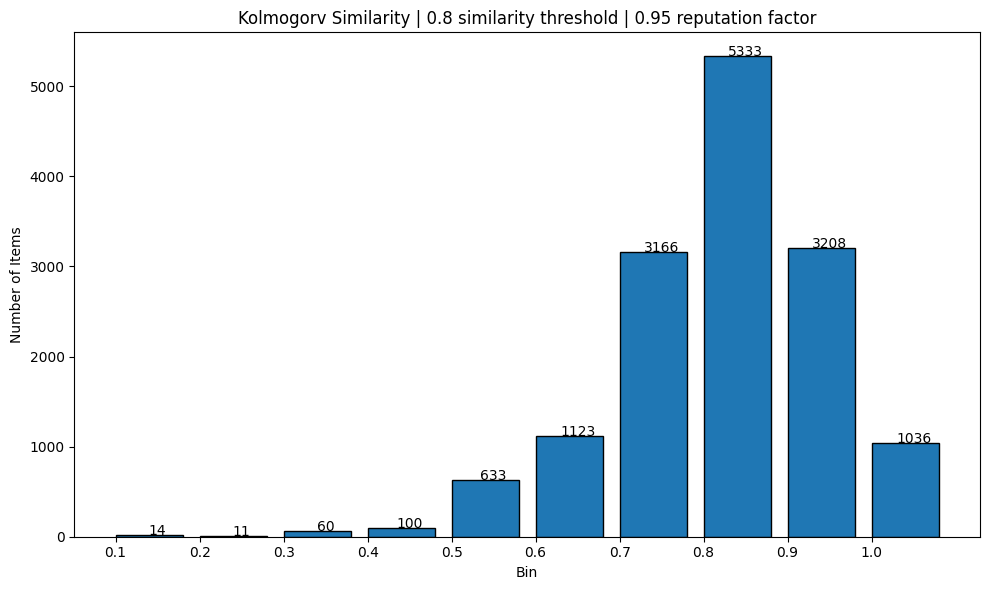

In [71]:
# Assuming user_groups is already defined
cluster_item_ratings = compute_cluster_ratings(df, user_groups)  # Step 1: Compute initial ratings
    
# Fill missing ratings
filled_ratings = fill_missing_ratings(cluster_item_ratings)

cluster_item_ratings_reputation = compute_reputation_adjusted_ratings(df, filled_ratings, user_groups)

#calculate average on top3 clusters
item_averages = calculate_item_averages(cluster_item_ratings_reputation)
print("item_averages: ", item_averages)
print("len(item_averages): ", len(item_averages))

# Initialize a dictionary to count occurrences of each value between 0.1 and 1.0
value_counts = {round(i * 0.1, 1): 0 for i in range(1, 11)}

# Iterate through the item_averages dictionary and count the occurrences of each value
for value in item_averages.values():
    rounded_value = round(value, 1)
    if rounded_value in value_counts:
        value_counts[rounded_value] += 1

# Extract bins and counts
bins = list(value_counts.keys())
counts = list(value_counts.values())

# Define bin edges from 0.1 to 1.0 (inclusive)
bin_edges = np.arange(0.1, 1.1, 0.1)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(bins, counts, width=0.08, align='edge', edgecolor='black')

# Adding numbers on top of bars
for i in range(len(counts)):
    plt.text(bins[i] + 0.05, counts[i] + 0.1, str(counts[i]), ha='center', fontsize=10)

# Set labels and title
plt.xlabel('Bin')
plt.ylabel('Number of Items')
plt.title('Kolmogorv Similarity | 0.8 similarity threshold | 0.95 reputation factor')

# Adjust the x-axis to display the correct bin edges
plt.xticks(bin_edges)

# Tight layout to avoid clipping
plt.tight_layout()

# Show the plot
plt.show()


